<a href="https://colab.research.google.com/github/Meghana-Yarlagadda/Plant-Disease-Detection/blob/main/Plant_Disease_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import os
import numpy as np #from arrays
import torch #traning and processing
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.utils import shuffle  #spilt the data and training
import pandas as pd  #for data frames

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
#define the class names
class_names = ['Apple___Apple_scab','Apple___Black_rot','Apple___Cedar_apple_rust','Apple___Healthy','Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot','Corn_(maize)___Northern_Leaf_Blight','Grape___Black_rot']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}
nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)
BATCH_SIZE = 32

In [19]:
#define transformations (data preprocessing)
transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [20]:
#Load datasets
train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/plant disease using CNN/plant disease using CNN/train',transform=transforms)
test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/plant disease using CNN/plant disease using CNN/test',transform=transforms)

In [21]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [22]:
# Check dataset size
n_train = len(train_dataset)
n_test = len(test_dataset)

print(f"Number of training examples: {n_train}")
print(f"Number of testing examples: {n_test}")
print(f"Each image is of size: {IMAGE_SIZE}")

Number of training examples: 106
Number of testing examples: 106
Each image is of size: (150, 150)


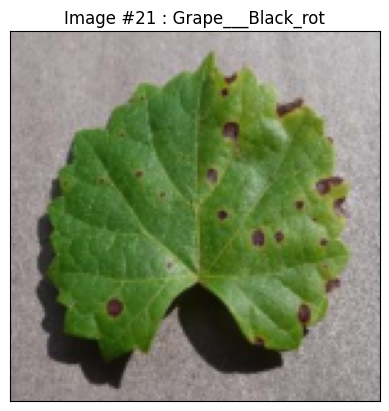

In [23]:
# Visualizing the dataset
def display_random_image(loader, class_names):
    """
    Display a random image from the dataset and its corresponding label.
    """
    # Get a batch of data
    dataiter = iter(loader)
    images, labels = next(dataiter)  # Use Python's built-in next() function

    index = np.random.randint(len(labels))  # Get a random index
    image = images[index].numpy().transpose(1, 2, 0)  # Transpose for correct display

    # Unnormalize the image for correct visualization (reverse of normalization)
    image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    image = np.clip(image, 0, 1)  # Clip to ensure valid pixel range

    plt.figure()
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title(f'Image #{index} : {class_names[labels[index]]}')
    plt.show()

# Call the function
display_random_image(train_loader, class_names)


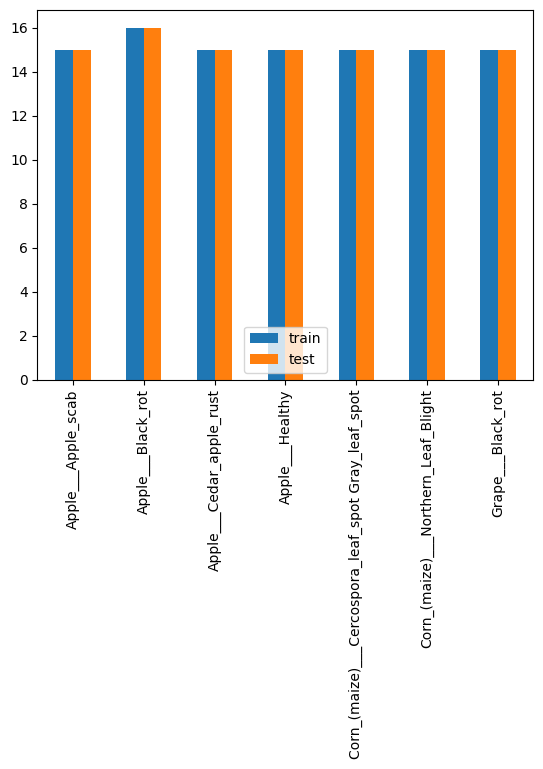

In [24]:
# Plotting dataset distribution
train_labels = [label for _, label in train_dataset]
test_labels = [label for _, label in test_dataset]
_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
              'test': test_counts}, index=class_names).plot.bar()
plt.show()

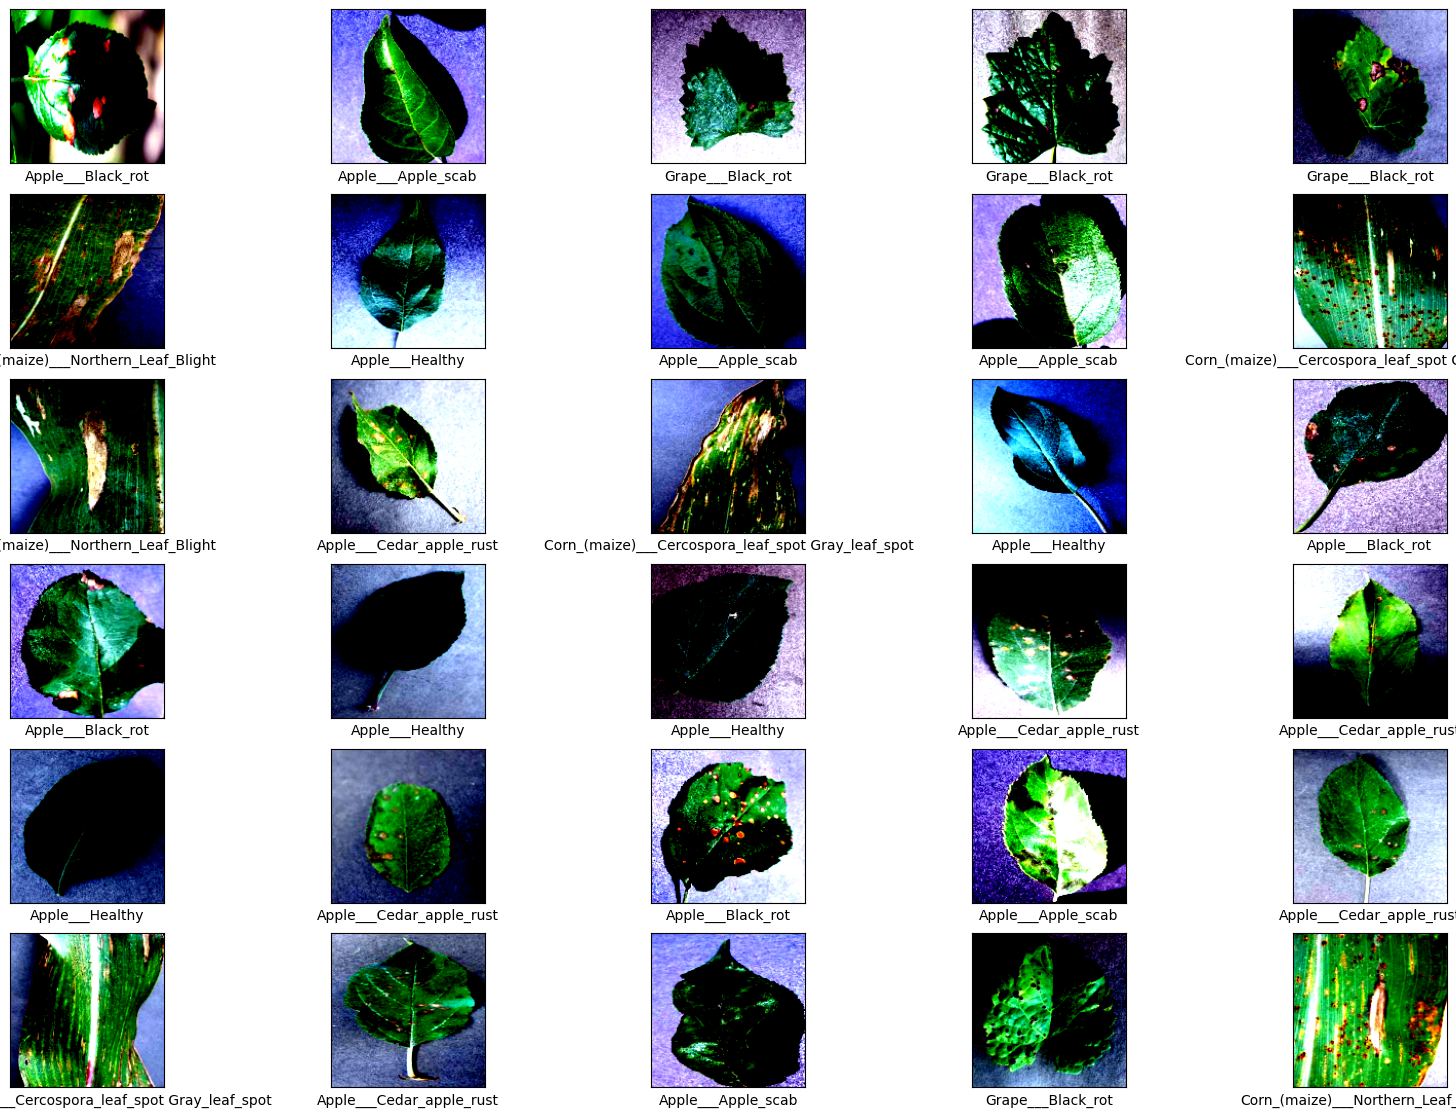

In [25]:
def display_examples(class_names, loader):
    num_examples = 30
    dataiter = iter(loader)
    images, labels = next(dataiter)

    plt.figure(figsize=(20, 14))
    for i in range(min(num_examples, len(images))):
        plt.subplot(6, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)

        # Convert tensor to numpy and clip values to [0, 1] range for imshow
        image = images[i].numpy().transpose(1, 2, 0)
        image = np.clip(image, 0, 1)  # Clipping values to the valid range

        plt.imshow(image)
        plt.xlabel(class_names[labels[i].item()])
    plt.show()
display_examples(class_names, train_loader)

In [26]:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    import torchvision
    import torchvision.transforms as transforms

    class CNN(nn.Module):
        def __init__(self):
            super(CNN, self).__init__()
            self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)  # 3 input channels for RGB images
            self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
            self.relu = nn.ReLU()
            self.dropout = nn.Dropout(p=0.5)

            # Calculate the size of the flattened feature vector
            self.flattened_size = self._get_flattened_size()

            # Define fully connected layers
            self.fc1 = nn.Linear(self.flattened_size, 128)  # Adjust based on the flattened size
            self.fc2 = nn.Linear(128, len(class_names))  # Output size is the number of classes

        def _get_flattened_size(self):
            # Use a dummy tensor to calculate the size after conv and pool layers
            with torch.no_grad():
                x = torch.zeros(1, 3, 150, 150)  # Input image size
                x = self.conv1(x)
                x = self.relu(x)
                x = self.pool(x)
                x = self.conv2(x)
                x = self.relu(x)
                x = self.pool(x)
                return x.view(-1).size(0)

        def forward(self, x):
            x = self.conv1(x)
            x = self.relu(x)
            x = self.pool(x)
            x = self.conv2(x)
            x = self.relu(x)
            x = self.pool(x)
            x = x.view(-1, self.flattened_size)
            x = self.fc1(x)
            x = self.relu(x)
            x = self.dropout(x)
            x = self.fc2(x)
            return x

    # Hyperparameters
    batch_size = 32  # Adjust batch size according to your dataset and GPU/CPU memory
    learning_rate = 0.001
    num_epochs = 5

    # Data transformations
    transform = transforms.Compose([
        transforms.Resize((150, 150)),  # Resize images to the required size
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Load datasets
    trainset = torchvision.datasets.ImageFolder(root=r'/content/drive/MyDrive/plant disease using CNN/plant disease using CNN/train', transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

    testset = torchvision.datasets.ImageFolder(root=r'/content/drive/MyDrive/plant disease using CNN/plant disease using CNN/test', transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

    # Define class names
    class_names = trainset.classes  # Get class names from the dataset

    # Initialize the model, loss function, and optimizer
    model = CNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(trainloader, 0):
            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

            running_loss += loss.item()
            if i % 100 == 99:  # Print every 100 mini-batches
                print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100:.4f}')
                running_loss = 0.0

    print('Finished Training')

    # Testing the model
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the test images: {100 * correct // total} %')


Finished Training
Accuracy of the network on the test images: 80 %


In [27]:
# After training the model
torch.save(model.state_dict(), 'Plant_Disease_Detection.pth')

The image is classified as: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot


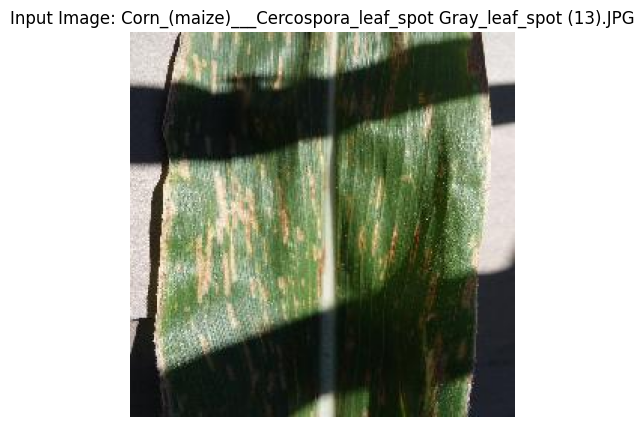

In [30]:
import os
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Define class names and model paths
class_names = ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___Healthy',
                'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Northern_Leaf_Blight', 'Grape___Black_rot']
model_path = 'Plant_Disease_Detection.pth'  # Update this path
image_path = '/content/drive/MyDrive/plant disease using CNN/plant disease using CNN/test/Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot/Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot (13).JPG' # Update this path

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def load_and_preprocess_image(image_path, transform):
    """
    Load and preprocess the image for model prediction.
    """
    image = Image.open(image_path).convert('RGB')  # Ensure the image is in RGB format
    image = transform(image)  # Apply transformations
    image = image.unsqueeze(0)  # Add a batch dimension
    return image

def predict_image(image, model, class_names):
    """
    Predict the class of the image using the model.
    """
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        return class_names[predicted.item()]

# Define the model architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)  # Adjust channels for RGB
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 37 * 37, 128)  # Adjust based on the output size from the last pooling layer
        self.fc2 = nn.Linear(128, len(class_names))
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(-1, 64 * 37 * 37)  # Adjust based on the output size from the last pooling layer
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize the model and load the weights
model = SimpleCNN()  # Use SimpleCNN if the trained model was simpler
model.load_state_dict(torch.load(model_path))

# Load and preprocess the image
image = load_and_preprocess_image(image_path, transform)

# Predict the class of the image
predicted_class = predict_image(image, model, class_names)

# Print the result
print(f'The image is classified as: {predicted_class}')

# Display the image
def show_image(image_path):
    """
    Display the image.
    """
    image = Image.open(image_path)
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f'Input Image: {os.path.basename(image_path)}')
    plt.show()

show_image(image_path)
